In [65]:
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
from nltk.corpus import stopwords
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
import glob
import os
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics


### Read in data

First section is only for the scored test set with generated summaries

In [9]:
# get max csv
# list_of_files = glob.glob('Z:/final_data/scored_data/scored_rouged_df*.csv') # * means all if need specific format then *.csv
# ckpt_text = max(list_of_files, key=os.path.getctime)
# print(ckpt_text)

# read in actual notes
# notes = pd.read_csv(ckpt_text,index_col=0,keep_default_na=False)

Z:/final_data/scored_data\scored_rouged_df.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,70,326) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
notes.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,scored_summaries,rouge-1-f,rouge-1-p,rouge-1-r,rouge-2-f,rouge-2-p,rouge-2-r,rouge-l-f,rouge-2-p.1,rouge-2-r.1
0,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
1,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
2,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
3,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
4,49,79,M,White,Not Hispanic or Latino,,11420608,O,No Show,Completed,...,,,,,,,,,,


In [11]:
# train dat
train_dta = pd.read_csv("Z:/final_data/cohorts_merged_training.csv",keep_default_na=False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,69,325) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
train_dta.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,comparison,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_diag_prior_to_visit,ild_status
0,49,79,M,White,Not Hispanic or Latino,,4860489,O,Completed,,...,,,,,,,4860489,2012-07-17,0,1
1,49,79,M,White,Not Hispanic or Latino,,4860489,O,Completed,,...,**DATE<[**2014-07-23**]>.,Left-sided AICD are unchanged. Sternal wires a...,No acute cardiopulmonary process.,"**NAME<AAA BBB>, MD I personally reviewed the...",4860489_1099048,"XR CHEST PA/LATERAL, **DATE<[**2015-01-12**]> ...",4860489,2012-07-17,0,1
2,49,79,M,White,Not Hispanic or Latino,,7460089,I,Completed,,...,**DATE<[**2018-06-03**]>,Right Port-A-Cath and left-sided ICD unchanged...,Stable chronic appearing right basilar opaciti...,**DATE<[**2018-08-28**]> 9:01 AM **NAME<III JJ...,7460089_116541,"XR CHEST PA/LATERAL, **DATE<[**2018-08-27**]> ...",4860489,2012-07-17,1,1
3,49,79,M,White,Not Hispanic or Latino,,7460089,I,Completed,,...,,,,,,,4860489,2012-07-17,1,1
4,49,79,M,White,Not Hispanic or Latino,,7727185,O,Completed,Canceled,...,,,,,,,4860489,2012-07-17,1,1


### Let's get only the rows with an impression to build off of. 

We'll need to grab the rows where the ild_diag_prior_to_visit is 0, and has a "finding"

In [30]:
train_dta.head().loc[train_dta.findings.notnull()]

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,comparison,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_diag_prior_to_visit,ild_status
0,49,79,M,White,Not Hispanic or Latino,,4860489,O,Completed,,...,,,,,,,4860489,2012-07-17,0,1
1,49,79,M,White,Not Hispanic or Latino,,4860489,O,Completed,,...,**DATE<[**2014-07-23**]>.,Left-sided AICD are unchanged. Sternal wires a...,No acute cardiopulmonary process.,"**NAME<AAA BBB>, MD I personally reviewed the...",4860489_1099048,"XR CHEST PA/LATERAL, **DATE<[**2015-01-12**]> ...",4860489,2012-07-17,0,1
2,49,79,M,White,Not Hispanic or Latino,,7460089,I,Completed,,...,**DATE<[**2018-06-03**]>,Right Port-A-Cath and left-sided ICD unchanged...,Stable chronic appearing right basilar opaciti...,**DATE<[**2018-08-28**]> 9:01 AM **NAME<III JJ...,7460089_116541,"XR CHEST PA/LATERAL, **DATE<[**2018-08-27**]> ...",4860489,2012-07-17,1,1
3,49,79,M,White,Not Hispanic or Latino,,7460089,I,Completed,,...,,,,,,,4860489,2012-07-17,1,1
4,49,79,M,White,Not Hispanic or Latino,,7727185,O,Completed,Canceled,...,,,,,,,4860489,2012-07-17,1,1


In [57]:
train_dta_ild = train_dta[(train_dta.ild_diag_prior_to_visit==0) & (train_dta.findings.str.len()>0)]
train_dta_ild.shape

(372970, 342)

### Spacy cleaning

Note english language is not installed. Somebody with sudo needs to run:

python -m spacy download en

@chantel Please submit a ticket

In [66]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

train_dta_ild['findings_cleaned'] = news['findings'].apply(normalize,lowercase=True,remove_stopwords=True)

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [58]:
train_dta_ild.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,comparison,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_diag_prior_to_visit,ild_status
1,49,79,M,White,Not Hispanic or Latino,,4860489,O,Completed,,...,**DATE<[**2014-07-23**]>.,Left-sided AICD are unchanged. Sternal wires a...,No acute cardiopulmonary process.,"**NAME<AAA BBB>, MD I personally reviewed the...",4860489_1099048,"XR CHEST PA/LATERAL, **DATE<[**2015-01-12**]> ...",4860489,2012-07-17,0,1
42,99,86,F,White,Not Hispanic or Latino,,5169683,O,Completed,,...,**DATE<[**2014-08-05**]>,Lung nodules previously visualized at the righ...,No interval change in size/number of pulmonary...,"**NAME<MMM NNN>, MD I personally reviewed the...",5169683_1115737,"XR CHEST PA/LATERAL, **DATE<[**2015-08-18**]> ...",,,0,0
46,99,86,F,White,Not Hispanic or Latino,,6697659,O,Completed,,...,**DATE<[**2015-06-23**]>,Right hemithorax volume loss. Bilateral pulmo...,No interval change in size/number of pulmonary...,**DATE<[**2016-06-19**]> 11:54 AM **NAME<RRR S...,6697659_1037161,"XR CHEST PA/LATERAL, **DATE<[**2016-06-19**]> ...",,,0,0
47,99,86,F,White,Not Hispanic or Latino,,7600512,O,Completed,,...,**DATE<[**2016-08-21**]>,Status post right upper lobectomy with right h...,No acute cardiopulmonary abnormalites identifi...,**DATE<[**2017-08-06**]> 2:51 PM **NAME<WWW XX...,7600512_138634,"XR CHEST PA/LATERAL, **DATE<[**2017-08-06**]> ...",,,0,0
50,104,84,M,White,Not Hispanic or Latino,,6751451,O,Completed,,...,Non-brain MRI 1 -- 20 -- **DATE<2010> \r\n\r\...,Unenhanced head CT: There is no detectable acu...,1. No acute intracranial process. 2. Age indet...,**DATE<[**2016-08-10**]> 4:05 PM **NAME<YYY Z...,6751451_912393,"CT HEAD WO, **DATE<[**2016-08-10**]> 3:55 PM ...",,,0,0


In [61]:
X = np.array(train_dta_ild.findings)
Y = np.array(train_dta_ild.ild_status)
print(X.shape)
print(Y.shape)


(372970,)
(372970,)


In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1)
print(X_train.shape)
print(X_test.shape)


(279727,)
(93243,)


In [63]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)


In [64]:
# test
X_test_dtm = vect.transform(np.array(X_test))
X_test_dtm


<93243x22163 sparse matrix of type '<class 'numpy.int64'>'
	with 5280050 stored elements in Compressed Sparse Row format>

## Model building

#### Naive bayes

In [69]:
nb = MultinomialNB()
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, Y_train)

Wall time: 391 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [70]:
# class preds
Y_pred_class_nb = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, Y_pred_class_nb))

0.5625837864504574


             precision    recall  f1-score   support

          0       0.97      0.55      0.70     86779
          1       0.11      0.74      0.19      6464

avg / total       0.91      0.56      0.66     93243

[[47643 39136]
 [ 1650  4814]]


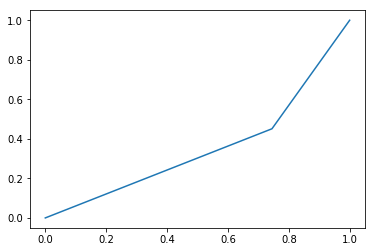

AUC: 0.35312229311250304


In [71]:
# calculate precision and recall
print(classification_report(Y_test, Y_pred_class_nb))

# calculate the confusion matrix
print(metrics.confusion_matrix(Y_test, Y_pred_class_nb))

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_class_nb, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)